# Neural Style Transfer - DevFest Nantes 2021 - IArt

 
<br>  
Brique n°1 de la conférence **IArt ou comment apprendre à une machine à tagger et à composer**
 
<br>  

<img src="images/image1.jpg" alt="Style Tranfer" />

### Objectifs
 
<br>  
- Introduction au Neural Style Transfer
<br>  
<br>  
- Transformer un texte en graphe 🎨🎨🎨

### Etapes

<br>  
1. A partir d'un texte, on va générer une première image de base
<br>  
    - Simple texte sur fond noir
    - On y applique quelques transformations simples
    - Il s'agit de notre image de base pour la *style transfer*  
<br>  
2. On va ensuite charger une image de tag
<br>  
    - Il s'agit de notre image de *style*  
<br>  
3. On définit un réseau de neurones et un ensemble de *loss* à optimiser
<br>  
    - On récupère un modèle de classification pré-entrainé sur des images (ici VGG19). Il va nous servir "d'extracteur de caractéristiques".
    - On va ensuite récupérer certaines couches intermédiaires du réseau de neurones, qu'on va par la suite utiliser pour caractériser le contenu et le style des images en entrée de notre modèle final.
    - Il nous faut ensuite définir deux fonctions de coûts. Une pour mesurer l'écart de style entre notre image produite par le modèle, et celle de style en entrée. L'autre pour limiter la déviation du "contenu" de l'image de base.  
<br>  
4. Entrainement
<br>  
    - Contrairement à un projet d'IA classique, on ne va pas chercher à optimiser le réseau, mais à optimiser de manière itérative l'image en entrée.
    - L'image va progressivement se transformer pour prendre le style souhaité.  
<br>  
5. On termine par tout automatiser dans une seule fonction
<br>  

---

### Imports

In [1]:
# Divers
import os
import math
import time
import functools
import random
import numpy as np
from datetime import datetime
from IPython.display import display, HTML, Javascript, clear_output

# Affichage
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# TensorFlow
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED' # Load compressed models from tensorflow_hub
import tensorflow_hub as hub

In [2]:
# Center figures
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

---

### Fonctions utilitaires

<br>  
On commence par définir certaines fonctions utilitaires :


- **hide_toggle** : permet de "masquer" certaines cellules de ce notebook, ce qui permet d'apporter un peu plus de clarté ;)   

- **load_img** : Fonction pour charger une image dans un Tensor

- **tensor_to_image** : Transforme un tensor en image (pour affichage)

- **imshow** : Fonction pour afficher un tensor en image

In [3]:
def hide_toggle(for_next=False, text_display='Toggle show/hide'):
    '''Function to hide a notebook cell'''
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    target_cell = this_cell  # target cell to control with toggle

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = f"""
        <script>
            function {js_f_name}() {{
                {target_cell}.find('div.input').toggle();
            }}

        </script>

        <a href="javascript:{js_f_name}()" id="{js_f_name}">{text_display}</a>
    """
    
    js = f'''
            var output_area = this;
            var cell_element = output_area.element.parents('.cell');
            var cell_idx = Jupyter.notebook.get_cell_elements().index(cell_element);
            var current_cell = Jupyter.notebook.get_cell(cell_idx);
            $(current_cell.element[0]).find('div.input').toggle();
            Jupyter.notebook.select(cell_idx +  1);
            Jupyter.notebook.focus_cell();
         '''

    display(HTML(html))
    display(Javascript(js))

hide_toggle(text_display='Toggle show/hide --- fonction hide_toggle')

<IPython.core.display.Javascript object>

In [4]:
def load_img(path_to_img, max_dim: int = 512):
    '''Fonction pour charger une image dans un Tensor
    
    Args:
        path_to_img (str): chemin vers l'image à charger
        max_dim (int): variable pour limiter la taille de l'image chargée
    Returns:
        Tensor: image chargée
    '''
    # Lecture de l'image
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # On reshape l'image (dimension max 512)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img


hide_toggle(text_display='Toggle show/hide --- fonction load_img')

<IPython.core.display.Javascript object>

In [5]:
def tensor_to_image(tensor):
    '''Transforme un tensor en image (pour affichage)
    
    Args: 
        tensor (Tensor): tensor à tranformer en image
    Returns:
        PIL.Image.Image: image à afficher
    '''
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)


hide_toggle(text_display='Toggle show/hide --- fonction tensor_to_image')

<IPython.core.display.Javascript object>

In [6]:
def imshow(image_tensor, title=None):
    '''Fonction pour afficher un tensor en image
    
    Args: 
        image_tensor (Tensor): tensor à afficher
    '''
    # Squeeze if needed
    if len(image_tensor.shape) > 3:
        image = tf.squeeze(image_tensor, axis=0)
    # Plot
    plt.imshow(image)
    if title is not None:
        plt.title(title)
        

hide_toggle(text_display='Toggle show/hide --- fonction imshow')

<IPython.core.display.Javascript object>

---

### 1. Génération d'une image à partir d'un texte

<br>  
- Création d'une image avec un simple texte sur fond noir
- Application de quelques transformations simples  

<br>   

On définit quelques fonctions pour clarifier le notebook :

- **WaveDeformer** : Classe qui permet d'appliquer une transformation de type "wave" à une image
- **generate_text_image** : Fonction pour générer une image simple à partir d'un texte

In [7]:
# Fonction pour appliquer une déformation de type "wave"

class WaveDeformer:
    
    def __init__(self, amplitude: float = 10., period: float = 40.):
        self.amplitude = amplitude
        self.period = period

    def transform(self, x, y):
        y = y + self.amplitude*math.sin(x/self.period)
        return x, y

    def transform_rectangle(self, x0, y0, x1, y1):
        return (*self.transform(x0, y0),
                *self.transform(x0, y1),
                *self.transform(x1, y1),
                *self.transform(x1, y0),
                )

    def getmesh(self, img):
        self.w, self.h = img.size
        gridspace = 20

        target_grid = []
        for x in range(0, self.w, gridspace):
            for y in range(0, self.h, gridspace):
                target_grid.append((x, y, 
                                    x + gridspace, y + gridspace))

        source_grid = [self.transform_rectangle(*rect)
                                 for rect in target_grid]

        return [t for t in zip(target_grid, source_grid)]
    
hide_toggle(text_display='Toggle show/hide --- classe WaveDeformer')

<IPython.core.display.Javascript object>

In [8]:
def generate_text_image(text1: str = 'VALEURIAD', text2: str = 'DEVFEST 2021',
                        with_wave: bool = False, wave_amplitude: float = 10.,
                        wave_period: float = 10.):
    '''Fonction pour générer une image simple à partir d'un texte
    
    Kwargs:
        text1 (str): texte à afficher - ligne 1
        text2 (str): texte à afficher - ligne 2
        with_wave (bool): si une transformation de type "wave" doit être appliquée à l'image à générer
        wave_amplitude (float): amplitude de la transformation "wave"
        wave_period (float): période de la transformation "wave"
    Returns:
        Image: image créée
    '''
    # Generate an empty image (black background)
    img = Image.new('RGB', (500, 500))
    # Blur the background a bit
    img = img.filter(ImageFilter.BoxBlur(3))
    
    # Add text
    d = ImageDraw.Draw(img)
    font = ImageFont.truetype('arial.ttf', 48)
    d.text((50, 150), text1, fill=(255, 0, 0), font=font)
    d.text((150, 250), text2, fill=(255, 0, 0), font=font)

    # Add blur again
    img = img.filter(ImageFilter.GaussianBlur(radius = 2))

    # Add wave transformation
    if with_wave:
        img = ImageOps.deform(img, WaveDeformer(amplitude=wave_amplitude, period=wave_period), resample=2)
    
    # Return the created image
    return img


hide_toggle(text_display='Toggle show/hide --- fonction generate_text_image')

<IPython.core.display.Javascript object>

In [9]:
# On va créer un dossier où sauvegarder toutes nos images
subfolder_name = datetime.now().strftime(f"experimentation_%Y_%m_%d-%H_%M_%S")
os.makedirs(subfolder_name)
subfolder_path = os.path.abspath(subfolder_name)
print(f"L'ensemble des images seront sauvegardées dans le répertoire {subfolder_path}")

L'ensemble des images seront sauvegardées dans le répertoire C:\Users\Alexandre\Dev\Valeuriad\devfest-2021\01_style_transfer\experimentation_2021_10_17-15_32_24


In [10]:
# On génère notre image de contenu
content_image = generate_text_image()

# Exemple avec Wave :
# content_image = generate_text_image(with_wave=True, wave_amplitude=10, wave_period=10)

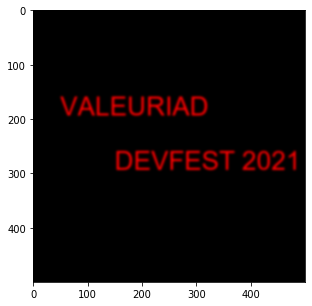

In [11]:
# Display it
plt.figure(figsize = (5, 5))
plt.imshow(content_image)
plt.show()

In [12]:
# Save it
content_path = os.path.join(subfolder_name, 'content_image.png')
content_image.save(content_path)

In [13]:
# Chargement de notre image de contenu en Tensor
content_image_tensor = load_img(content_path)

---

### 2. Chargement d'une image de *style*

<br>  
Nous avons récupéré un ensemble de tags qui sont mis à disposition dans le répertoire `./ìmages_tags`. Libre à vous d'en rajouter.

In [14]:
# On liste l'ensemble des tags à disposition
tags_dir_path = os.path.abspath('./images_tags')
list_tags = [f for f in os.listdir(tags_dir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
print("Ensemble des tags à disposition :")
for tag in list_tags:
    print(f'  - {tag}')

Ensemble des tags à disposition :
  - graf1.jpg
  - graf10.jpg
  - graf11.jpg
  - graf2.jpg
  - graf3.jpg
  - graf4.jpg
  - graf5.jpg
  - graf6.jpg
  - graf7.jpg
  - graf8.jpg
  - graf9.jpg


In [15]:
# Chargement de l'image de style
graf_to_use = 'graf2.jpg'
style_image_tensor = load_img(os.path.join(tags_dir_path, graf_to_use))

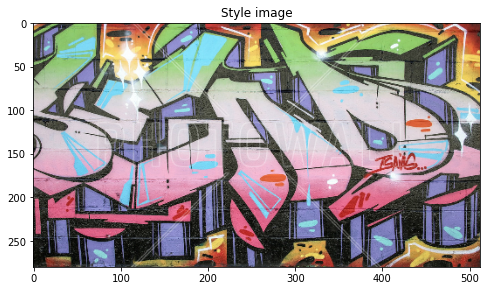

In [16]:
# Display it
imshow(style_image_tensor, "Style image")

In [17]:
# On la sauvegarde dans le dossier de notre expérimentation
style_path = os.path.join(subfolder_name, 'style_image.png')
tensor_to_image(style_image_tensor).save(style_path)

---

### 3. Définition du réseau de neurones

<br>  
- On récupère un modèle de classification pré-entrainé sur des images (ici VGG19). Il va nous servir "d'extracteur de caractéristiques".
- On va ensuite récupérer certaines couches intermédiaires du réseau de neurones, qu'on va par la suite utiliser pour caractériser le contenu et le style des images en entrée de notre modèle final.
- Il nous faut ensuite définir deux fonctions de coûts. Une pour mesurer l'écart de style entre notre image produite par le modèle, et celle de style en entrée. L'autre pour limiter la déviation du "contenu" de l'image de base.  

<br>   

On va commencer par définir certaines fonctions/classes utilitaire pour le modèle :  

- **clip_0_1** : Fonction pour limiter les valeurs des pixels entre 0 et 1
- **gram_matrix** : Fonction pour calculer une matrice de gram pour un tensor donné. Le résultat donne une représentation du style d'une image, ce qui va ensuite nous permettre de comparer des "styles"
- **vgg_layers** : Fonction pour créer un nouveau modèle à partir d'un modèle VGG19, qui prend en sortie certaines couches intermédiaires de VGG19.
- **StyleContentModel** : Classe principale pour notre modèle
- **style_content_loss** : Fonction de coût de notre modèle

In [18]:
def clip_0_1(image):
    '''Fonction pour limiter les valeurs des pixels entre 0 et 1
    
    Args:
        image (tensor): image à traiter
    return:
        tensor: image avec pixels bornés entre 0 et 1
    '''
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

hide_toggle(text_display='Toggle show/hide --- fonction clip_0_1')

<IPython.core.display.Javascript object>

In [19]:
def gram_matrix(input_tensor):
    '''Fonction pour calculer une matrice de gram pour un tensor donné
    Le résultat donne une représentation du style d'une image,
    ce qui va ensuite nous permettre de comparer des "styles".
    
    Args:
        input_tensor (tensor): représentation sur laquelle calculée une matrice de gram
    Results:
        tensor: matrice de gram
    '''
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

hide_toggle(text_display='Toggle show/hide --- fonction gram_matrix')

<IPython.core.display.Javascript object>

In [20]:
def vgg_layers(layer_names):
    '''Fonction pour créer un nouveau modèle à partir d'un modèle VGG19,
    qui prend en sortie certaines couches intermédiaires de VGG19.
    
    On récupère le modèle sans la dernière couche de classification,
    et on définit un nouveau "méta" modèle qui prend en sortie les layers intermédiaires souhaités.
    
    Args:
        layer_names (list): liste des couches intermédiaires à utiliser en sortie
    Returns:
        Model: le "méta" modèle qu'on va utiliser pour le style transfer
    ''' 
    # Chargement d'un modèle VGG19 pré-entrainé sur imagenet
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False # On désactive l'entrainement du modèle

    # On définit notre sortie
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # Méta modèle
    model = tf.keras.Model([vgg.input], outputs)
    return model

hide_toggle(text_display='Toggle show/hide --- fonction vgg_layers')

<IPython.core.display.Javascript object>

In [21]:
class StyleContentModel(tf.keras.models.Model):
    '''Classe principale pour notre modèle'''
    
    def __init__(self, style_layers, content_layers):
        '''On initialise notre modèle à partir des couches intermédiaires souhaitées
        
        Args:
            style_layers : Liste des couches de style souhaitées
            content_layers : Liste des couches de contenu souhaitées
        '''
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers) # ORDRE IMPORTANT ICI !
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        '''Appel au modèle
        Args:
            inputs : données en entrée
                On s'attend à avoir des valeurs entre 0 et 1
        Returns:
            dict: dictionnaire avec les résultats de chaque couche intermédiaires souhaitées
        '''
        # Preprocessing pour VGG19 (on veut des données entre 0 et 255)
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        
        # Forward pass
        outputs = self.vgg(preprocessed_input)
        # On récupère les sorties (l'ordre de def des outputs est important ici)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # Pour les "styles" on récupère les matrices de gram
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # Return
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}
    

hide_toggle(text_display='Toggle show/hide --- classe StyleContentModel')

<IPython.core.display.Javascript object>

In [22]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight,
                       num_style_layers, num_content_layers):
    '''Fonction de coût de notre modèle
    
    Args:
        outputs: résultats de la forward pass
        style_targets: targets pour le "style"
        content_targets: targets pour le "contenu"
        style_weight: poids associé au "style"
        content_weight: poids associé au "contenu"
        num_style_layers: nombre de layers "style" de notre model
        num_content_layers: nombre de layers "contenu" de notre model
    
    Returns:
        float: loss calculée
    '''
    # Loss sur le style
    style_outputs = outputs['style']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss = style_loss / num_style_layers

    # Loss sur le contenu
    content_outputs = outputs['content']
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss = content_loss / num_content_layers
    
    # Final loss
    loss = (style_weight * style_loss) + (content_weight * content_loss)
    return loss

hide_toggle(text_display='Toggle show/hide --- fonction style_content_loss')

<IPython.core.display.Javascript object>

In [23]:
# On commence par afficher l'ensemble des couches d'un modèle VGG19 
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print("Ensemble des couches d'un modèle VGG19 :")
for layer in vgg.layers:
    print(f" - {layer.name}")

Ensemble des couches d'un modèle VGG19 :
 - input_1
 - block1_conv1
 - block1_conv2
 - block1_pool
 - block2_conv1
 - block2_conv2
 - block2_pool
 - block3_conv1
 - block3_conv2
 - block3_conv3
 - block3_conv4
 - block3_pool
 - block4_conv1
 - block4_conv2
 - block4_conv3
 - block4_conv4
 - block4_pool
 - block5_conv1
 - block5_conv2
 - block5_conv3
 - block5_conv4
 - block5_pool


In [24]:
# On choisit les couches à utiliser (libre à vous de modifier ces listes)

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [25]:
# A partir de ces couches, on définit notre model
extractor = StyleContentModel(style_layers, content_layers)

In [26]:
# On applique le modèle à nos deux images de base
# On garde les résultats de chaque couche pour ces images : on va optimiser là dessus
style_targets = extractor(style_image_tensor)['style']
content_targets = extractor(content_image_tensor)['content']

In [27]:
# On définit l'optimizer ainsi que les paramètres de calcul de loss (modifiables par l'utilisateur)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

---

### 4. Entrainement

<br>  
- Contrairement à un projet d'IA classique, on ne va pas chercher à optimiser le réseau, mais à optimiser de manière itérative l'image en entrée.
- L'image va progressivement se transformer pour prendre le style souhaité.  

In [28]:
# Image en entrée de notre modèle
image_input = tf.Variable(content_image_tensor)

In [29]:
# Fonction de backpropagation, spécifique à notre image en input
@tf.function()
def train_step(image):
    # On applique le modèle et on calcul la loss
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets,
                                  style_weight, content_weight,
                                  extractor.num_style_layers, extractor.num_content_layers)
        # On calcul le gradient sur notre image en entrée & on l'applique (via notre optimizer)
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        # On termine en limitant la valeur des pixels de 0 à 1
        image.assign(clip_0_1(image))

In [30]:
# On va compter le nombre de steps
# Permet de relancer le prochain bloc autant de fois que souhaité
step = 0

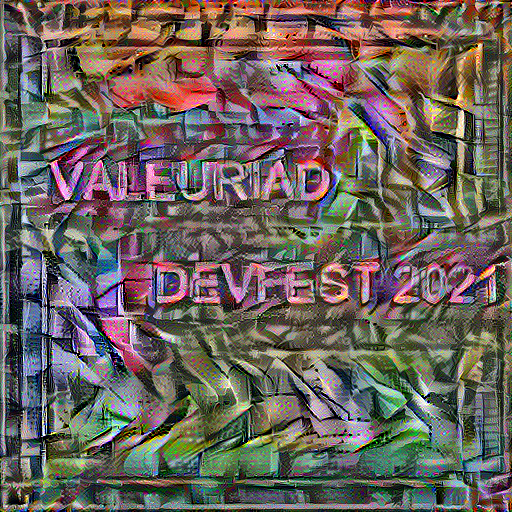

Train step: 1000
Total time: 187.9


In [31]:
# Entrainement !
start = time.time()
nb_steps = 1000 # A changer par l'utilisateur
display_period = 100
for n in range(nb_steps):
    step += 1
    train_step(image_input)
    print(".", end='', flush=True)
    if step % display_period == 0:
        clear_output(wait=True)
        display(tensor_to_image(image_input))
        print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [32]:
# On sauvegarde le résultat final
save_path = os.path.join(subfolder_name, f'result_image_step_{step}.png')
tensor_to_image(image_input).save(save_path)

---

### 5. Automatisation

<br>  
On va automatiser tout ce notebook dans une seule fonction  

Arguments :
- **image_content_path** (str): chemin vers une image de contenu à utiliser en entrée  
    Par défault à None -> on génère une image avec un texte  
- **text1** (str): texte à afficher - ligne 1
- **text2** (str): texte à afficher - ligne 2
- **with_wave** (bool): si une transformation de type "wave" doit être appliquée à l'image à générer
- **wave_amplitude** (float): amplitude de la transformation "wave"
- **wave_period** (float): période de la transformation "wave"
- **style_image_name** (str): nom de l'image de style (dans ./images_tags/)
- **img_max_dim** (int): variable pour limiter la taille des images chargées
- **style_layers** (list): layer de style à utiliser
- **content_layers** (list): layer de contenu à utiliser
- **lr** (float): learning rate
- **style_weight** (float): poids de "style"
- **content_weight** (float): poids de "contenu"
- **nb_steps** (int): nombre de steps pour l'apprentissage
- **display_period** (int): période d'affichage du résultat

In [33]:
def automatisation(image_content_path: str = None,
                   text1: str = 'VALEURIAD', text2: str = 'DEVFEST 2021',
                   with_wave: bool = False, wave_amplitude: float = 10.,
                   wave_period: float = 10., style_image_name = 'graf2.jpg',
                   img_max_dim: int = 512,
                   style_layers: list = ['block1_conv1',
                                         'block2_conv1',
                                         'block3_conv1', 
                                         'block4_conv1', 
                                         'block5_conv1'],
                   content_layers: list = ['block5_conv2'],
                   lr: float = 0.02, style_weight: float = 1e-2, content_weight: float = 1e4,
                   nb_steps: int = 1000, display_period: int = 100                   
                  ):
    '''Fonction pour automatiser ce notebook
    
    Kwargs:
        image_content_path (str): chemin vers une image de contenu à utiliser en entrée
            Par défault à None -> on génère une image avec un texte
        text1 (str): texte à afficher - ligne 1
        text2 (str): texte à afficher - ligne 2
        with_wave (bool): si une transformation de type "wave" doit être appliquée à l'image à générer
        wave_amplitude (float): amplitude de la transformation "wave"
        wave_period (float): période de la transformation "wave"
        style_image_name (str): nom de l'image de style (dans ./images_tags/)
        img_max_dim (int): variable pour limiter la taille des images chargées
            Attention, une trop grande valeur peut entrainer un ralentissement dans l'entrainement
        style_layers (list): layer de style à utiliser
        content_layers (list): layer de contenu à utiliser
        lr (float): learning rate
        style_weight (float): poids de "style"
        content_weight (float): poids de "contenu"
        nb_steps (int): nombre de steps pour l'apprentissage
        display_period (int): période d'affichage du résultat
    Returns:
        Tensor: image finale
    '''
    
    ###
    ### 1. Génération d'une image à partir d'un texte
    ###
    
    # On va créer un dossier où sauvegarder toutes nos images
    subfolder_name = datetime.now().strftime(f"experimentation_%Y_%m_%d-%H_%M_%S")
    os.makedirs(subfolder_name)
    subfolder_path = os.path.abspath(subfolder_name)
    print(f"L'ensemble des images seront sauvegardées dans le répertoire {subfolder_path}")
    
    # Si une image de contenu est renseignée, on charge cette image
    if image_content_path is not None:
        content_image = tensor_to_image(load_img(image_content_path, max_dim=img_max_dim))
    # Sinon, on génère une image
    else:
        # On génère notre image de contenu
        content_image = generate_text_image(text1=text1, text2=text2, with_wave=with_wave,
                                            wave_amplitude=wave_amplitude, wave_period=wave_period)
    
    # Display it
    plt.figure(figsize = (5, 5))
    plt.imshow(content_image)
    plt.title('Image de contenu')
    
    # Save it
    content_path = os.path.join(subfolder_name, 'content_image.png')
    content_image.save(content_path)

    # Chargement de notre image de contenu en Tensor
    content_image_tensor = load_img(content_path, max_dim=img_max_dim)
    
    ###
    ### 2. Chargement d'une image de style
    ###
    
    # Chargement de l'image de style
    tags_dir_path = os.path.abspath('./images_tags')
    style_image_tensor = load_img(os.path.join(tags_dir_path, style_image_name), max_dim=img_max_dim)
    # Display it
    
    imshow(style_image_tensor, "Image de style")
    # On la sauvegarde dans le dossier de notre expérimentation
    style_path = os.path.join(subfolder_name, 'style_image.png')
    tensor_to_image(style_image_tensor).save(style_path)
    
    ###
    ### 3. Définition du réseau de neurone
    ###
    
    # On définit notre model
    extractor = StyleContentModel(style_layers, content_layers)

    # On applique le modèle à nos deux images de base
    # On garde les résultats de chaque couche pour ces images : on va optimiser là dessus
    style_targets = extractor(style_image_tensor)['style']
    content_targets = extractor(content_image_tensor)['content']

    # On définit l'optimizer
    opt = tf.optimizers.Adam(learning_rate=lr, beta_1=0.99, epsilon=1e-1)
    
    ###
    ### 4. Entrainement
    ###
    
    # Image en entrée de notre modèle
    image_input = tf.Variable(content_image_tensor)

    # Fonction de backpropagation, spécifique à notre image en input
    @tf.function()
    def train_step(image):
        # On applique le modèle et on calcul la loss
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs, style_targets, content_targets,
                                      style_weight, content_weight,
                                      extractor.num_style_layers, extractor.num_content_layers)
            # On calcul le gradient sur notre image en entrée & on l'applique (via notre optimizer)
            grad = tape.gradient(loss, image)
            opt.apply_gradients([(grad, image)])
            # On termine en limitant la valeur des pixels de 0 à 1
            image.assign(clip_0_1(image))

    # On va compter le nombre de steps
    step = 0

    # Entrainement !
    start = time.time()
    for n in range(nb_steps):
        step += 1
        train_step(image_input)        
        print(".", end='', flush=True)
        if step % display_period == 0:
            clear_output(wait=True)
            display(tensor_to_image(image_input))
            print("Train step: {}".format(step))
    end = time.time()
    print("Total time: {:.1f}".format(end-start))
    
    # On sauvegarde le résultat final
    save_path = os.path.join(subfolder_name, f'result_image_step_{step}.png')
    tensor_to_image(image_input).save(save_path)
    
    # NEW : on va aussi sauvegarder une version "cropper" de l'image si pas d'image content en entrée
    # Valeurs de crop en dur, liés à la génération du texte de base
    if image_content_path is None:        
        save_path = os.path.join(subfolder_name, f'result_image_cropped_step_{step}.png')
        tensor_to_image(image_input).crop((20, 100, 510, 350)).save(save_path)

    return image_input    


hide_toggle(text_display='Toggle show/hide --- fonction automatisation')

<IPython.core.display.Javascript object>

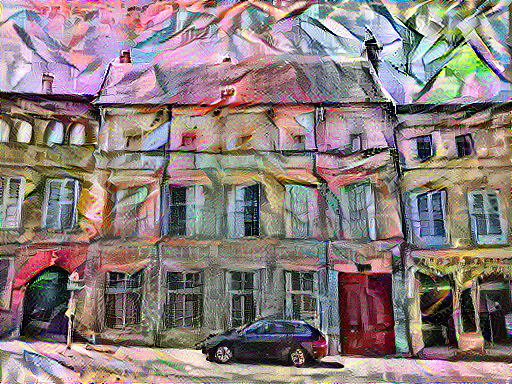

Train step: 1000
Total time: 61.9


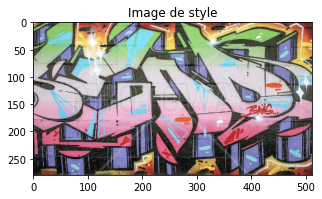

In [34]:
_ = automatisation(image_content_path='./images/image2.jpg', style_image_name='graf2.jpg')

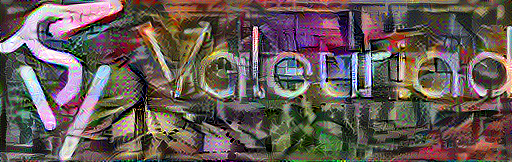

Train step: 1000
Total time: 31.1


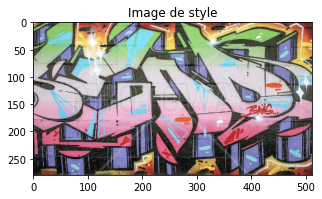

In [35]:
_ = automatisation(image_content_path='./images/image3.jpg', style_image_name='graf2.jpg')

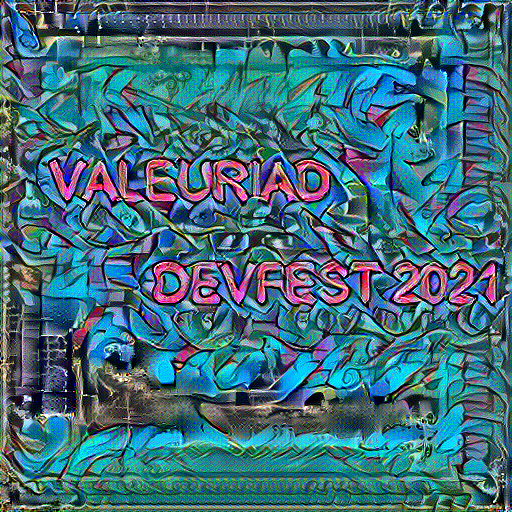

Train step: 1000
Total time: 90.3


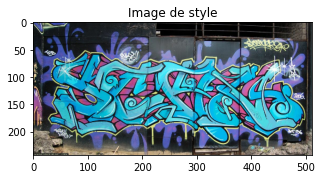

In [36]:
_ = automatisation(style_image_name = 'graf8.jpg', content_layers=['block4_conv2'], style_weight=0.1, content_weight=50, display_period=100,
                   style_layers = ['block1_conv1',
                                   'block1_conv2',
                                   'block2_conv1',
                                   'block2_conv2',
                                   'block3_conv1', 
                                   'block4_conv1', 
                                   'block5_conv1']
                   )

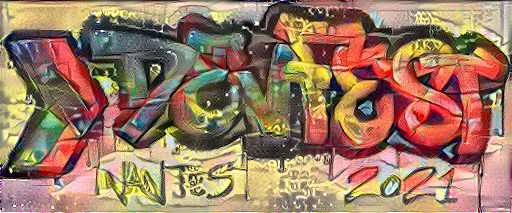

Train step: 1000
Total time: 42.9


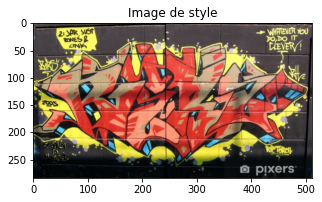

In [37]:
_ = automatisation(image_content_path='./images/image5.jpg', style_image_name = 'graf9.jpg', content_layers=['block4_conv2'], style_weight=0.1, content_weight=50, display_period=100,
                   style_layers = ['block1_conv1',
                                   'block1_conv2',
                                   'block2_conv1',
                                   'block2_conv2',
                                   'block3_conv1', 
                                   'block4_conv1', 
                                   'block5_conv1']
                   )

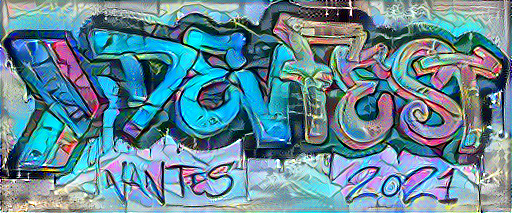

Train step: 1000
Total time: 42.4


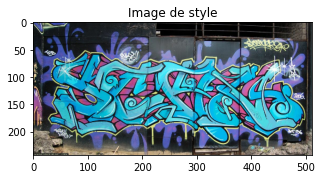

In [38]:
_ = automatisation(image_content_path='./images/image5.jpg', style_image_name = 'graf8.jpg', content_layers=['block4_conv2'], style_weight=0.1, content_weight=50, display_period=100,
                   style_layers = ['block1_conv1',
                                   'block1_conv2',
                                   'block2_conv1',
                                   'block2_conv2',
                                   'block3_conv1', 
                                   'block4_conv1', 
                                   'block5_conv1']
                   )

---

### Misc

On peut aussi réutiliser des modèles pré-entrainés pour le style transfer

In [40]:
# Chargement d'un modèle
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [41]:
# Application du modèle à nos images
stylized_image = hub_model(tf.constant(content_image_tensor), tf.constant(style_image_tensor))[0]

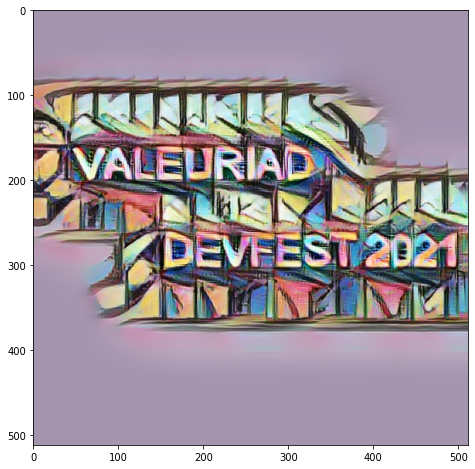

In [42]:
# Display it
imshow(stylized_image)

### Références :

- [A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf), *Leon A. Gatys and Alexander S. Ecker and Matthias Bethge*, 2015  
- [Exploring the structure of a real-time, arbitrary neural artistic stylization network](https://arxiv.org/pdf/1705.06830.pdf), *Golnaz Ghiasi and Honglak Lee and Manjunath Kudlur and Vincent Dumoulin and Jonathon Shlens*, 2017
